In [31]:
%matplotlib inline
%reload_ext autoreload

In [32]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from tqdm.auto import tqdm
from tensorboardX import SummaryWriter

import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [33]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [34]:
from src.data.gp_curves import GPCurvesReader
from src.models.model import LatentModel

## Util

In [35]:
def set_seed(n=42):
    np.random.seed(n)
    torch.manual_seed(n)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [36]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
          target_x[0, :, 0],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.2,
          facecolor='#65c9f7',
          interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()

In [37]:
def test(model, dataset_test, writer=None, plot=False, global_step=None, seed=42):
    model.eval()
    with torch.no_grad():
        data_test = dataset_test.generate_curves()

        (context_x, context_y), target_x = data_test.query
        target_y = data_test.target_y

        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        target_y = target_y.cuda()

        y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x, target_y)

        # Lets order the result, for plotting
        target_inds = torch.argsort(target_x[0, :, 0])
        target_x = target_x[:, target_inds, :]
        target_y = target_y[:, target_inds, :]
        context_inds = torch.argsort(context_x[0, :, 0])
        context_y = context_y[:, context_inds, :]
        context_x = context_x[:, context_inds, :]
        y_pred = y_pred[:, target_inds, :]
        y_std = y_std[:, target_inds, :]
        
        if writer is not None:
            writer.add_scalar('val/loss', loss, global_step=global_step)
            writer.add_scalar('val/y_std', y_std.mean(), global_step=global_step)
            writer.add_scalar('val/mse_loss', mse_loss, global_step=global_step)
            writer.add_scalar('val/kl', kl.mean(), global_step=global_step)
        
        if plot:
            set_seed(seed)
            fig = plt.figure()
            plt.title(f"Iter {global_step}")            
            plot_functions(target_x.detach().cpu().numpy(),
                           target_y.detach().cpu().numpy(),
                           context_x.detach().cpu().numpy(),
                           context_y.detach().cpu().numpy(),
                           y_pred.detach().cpu().numpy(),
                           y_std.detach().cpu().numpy())
            
            writer.add_figure('test', fig, global_step=global_step, close=False)
            plt.show()
            
    return y_pred, kl, loss, y_std

# Init

In [38]:

MAX_CONTEXT_POINTS = 50 
random_kernel_parameters=True 

dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)

dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)



## Replicate ANP paper

In [39]:
epochs = 100000
PLOT_AFTER = 10000
PRINT_AFTER = 1000

runs/Feb01_16-07-37_mjcdesktop-anp_1d_reg


train: 0 loss= 1.022 val_loss= 1.164


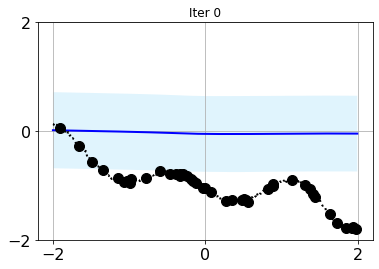

train: 1000 loss= 0.5298 val_loss= 0.9961
train: 2000 loss= 0.4239 val_loss= 0.8271
train: 3000 loss= 0.04399 val_loss= 0.5867
train: 4000 loss=-0.3301 val_loss= 0.8107
train: 5000 loss= 0.4517 val_loss=-1.358
train: 6000 loss= 0.001537 val_loss= 0.1418
train: 7000 loss=-0.2426 val_loss=-0.9051
train: 8000 loss= 0.2109 val_loss= 0.4143
train: 9000 loss= 0.07544 val_loss= 0.7437
train: 10000 loss= 0.7867 val_loss=-0.3666


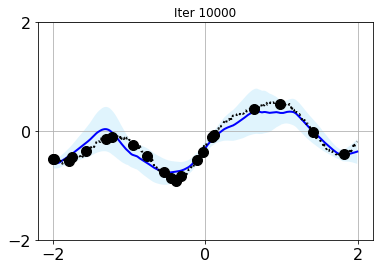

train: 11000 loss= 0.07031 val_loss= 0.03497
train: 12000 loss=-0.05091 val_loss= 0.2469
train: 13000 loss=-0.6072 val_loss=-0.1233
train: 14000 loss=-0.8565 val_loss= 0.6324
train: 15000 loss= 0.07174 val_loss=-1.635
train: 16000 loss=-0.4332 val_loss=-0.1369
train: 17000 loss=-0.4748 val_loss=-1.025
train: 18000 loss=-0.1203 val_loss=-0.06882
train: 19000 loss=-0.2705 val_loss= 1.093
train: 20000 loss= 0.6047 val_loss=-0.5318


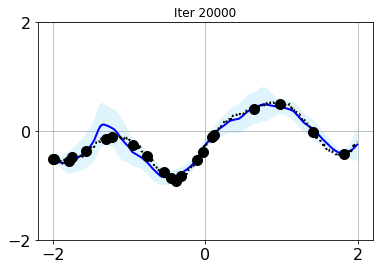

train: 21000 loss= 0.2304 val_loss=-0.1315
train: 22000 loss=-0.1885 val_loss= 0.04099
train: 23000 loss=-0.8853 val_loss=-0.5017
train: 24000 loss=-0.9157 val_loss= 0.4445
train: 25000 loss=-0.03504 val_loss=-1.767
train: 26000 loss=-0.6069 val_loss=-0.3324
train: 27000 loss=-0.6874 val_loss=-1.327
train: 28000 loss=-0.2541 val_loss=-0.09209
train: 29000 loss=-0.4341 val_loss= 1.182
train: 30000 loss= 0.3092 val_loss=-0.7948


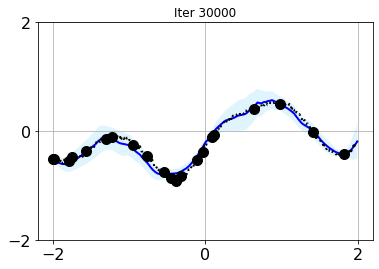

train: 31000 loss= 0.3467 val_loss=-0.147
train: 32000 loss=-0.3655 val_loss=-0.04438
train: 33000 loss=-1.062 val_loss=-0.5238
train: 34000 loss=-1.104 val_loss= 0.257
train: 35000 loss=-0.1402 val_loss=-1.82
train: 36000 loss=-0.7252 val_loss=-0.2135
train: 37000 loss=-0.8674 val_loss=-1.468
train: 38000 loss=-0.4853 val_loss=-0.1831
train: 39000 loss=-0.5404 val_loss= 1.302
train: 40000 loss= 0.1784 val_loss=-0.7937


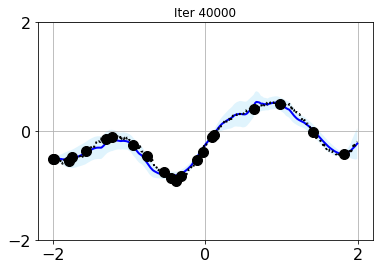

train: 41000 loss= 0.5599 val_loss=-0.1626
train: 42000 loss=-0.5496 val_loss=-0.1829
train: 43000 loss=-1.236 val_loss=-0.6471
train: 44000 loss=-1.201 val_loss= 0.1932
train: 45000 loss=-0.1587 val_loss=-1.955
train: 46000 loss=-0.8089 val_loss=-0.4458
train: 47000 loss=-0.9849 val_loss=-1.459
train: 48000 loss=-0.6127 val_loss=-0.1561
train: 49000 loss=-0.5869 val_loss= 1.431
train: 50000 loss= 0.05727 val_loss=-0.8966


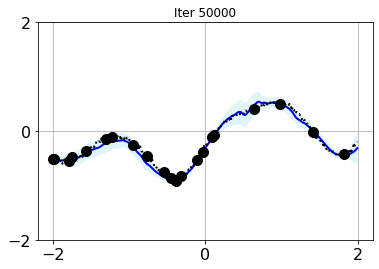

train: 51000 loss= 0.3433 val_loss=-0.2608
train: 52000 loss=-0.6517 val_loss=-0.3402
train: 53000 loss=-1.316 val_loss=-0.7089
train: 54000 loss=-1.252 val_loss= 0.1413
train: 55000 loss=-0.1212 val_loss=-2.049
train: 56000 loss=-0.911 val_loss=-0.5511
train: 57000 loss=-1.067 val_loss=-1.474
train: 58000 loss=-0.6328 val_loss=-0.1816
train: 59000 loss=-0.6415 val_loss= 1.425
train: 60000 loss=-0.03002 val_loss=-0.9892


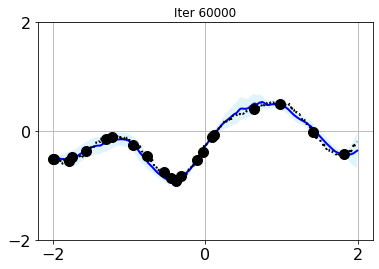

train: 61000 loss= 0.1685 val_loss=-0.3074
train: 62000 loss=-0.6884 val_loss=-0.4832
train: 63000 loss=-1.371 val_loss=-0.7573
train: 64000 loss=-1.325 val_loss= 0.0732
train: 65000 loss=-0.2572 val_loss=-2.091
train: 66000 loss=-0.9498 val_loss=-0.5306
train: 67000 loss=-1.147 val_loss=-1.504
train: 68000 loss=-0.5728 val_loss=-0.2233
train: 69000 loss=-0.6582 val_loss= 1.293
train: 70000 loss=-0.08883 val_loss=-1.121


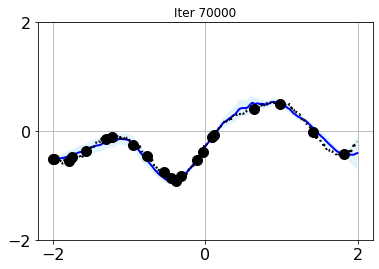

train: 71000 loss=-0.01866 val_loss=-0.4101
train: 72000 loss=-0.7331 val_loss=-0.4254
train: 73000 loss=-1.388 val_loss=-0.6802
train: 74000 loss=-1.333 val_loss= 0.07043
train: 75000 loss=-0.361 val_loss=-2.153
train: 76000 loss=-1.023 val_loss=-0.5553
train: 77000 loss=-1.163 val_loss=-1.52
train: 78000 loss=-0.5401 val_loss=-0.109
train: 79000 loss=-0.7097 val_loss= 1.312
train: 80000 loss=-0.1576 val_loss=-1.143


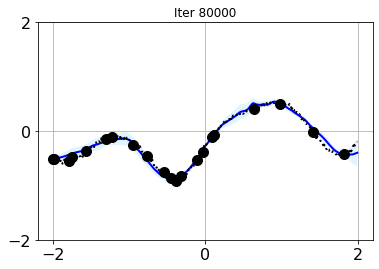

train: 81000 loss=-0.1231 val_loss=-0.441
train: 82000 loss=-0.7588 val_loss=-0.5596
train: 83000 loss=-1.447 val_loss=-0.7187
train: 84000 loss=-1.452 val_loss= 0.03446
train: 85000 loss=-0.4053 val_loss=-2.196
train: 86000 loss=-1.026 val_loss=-0.5255
train: 87000 loss=-1.18 val_loss=-1.591
train: 88000 loss=-0.6189 val_loss=-0.2184
train: 89000 loss=-0.7835 val_loss= 0.982
train: 90000 loss=-0.2503 val_loss=-1.158


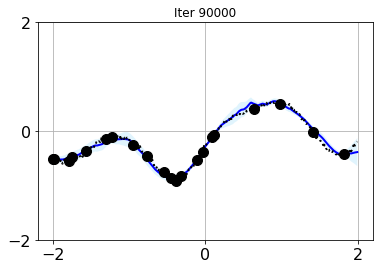

train: 91000 loss= 0.01111 val_loss=-0.5071
train: 92000 loss=-0.8187 val_loss=-0.5373
train: 93000 loss=-1.51 val_loss=-0.8606
train: 94000 loss=-1.489 val_loss=-0.04642
train: 95000 loss=-0.4914 val_loss=-2.129
train: 96000 loss=-1.122 val_loss=-0.6488
train: 97000 loss=-1.238 val_loss=-1.619
train: 98000 loss=-0.6839 val_loss=-0.2788
train: 99000 loss=-0.8457 val_loss= 0.7723



In [40]:


writer = SummaryWriter(comment='-anp_1d_reg')
print(writer.logdir)

hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="multihead",
    det_enc_self_attn_type="multihead",
    det_enc_cross_attn_type="multihead")
model = LatentModel(**hparams).cuda()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter % PLOT_AFTER == 0:
        test(model, dataset_test, writer, plot=True, global_step=n_iter)
        
        test(model, dataset_train, writer, plot=True, global_step=i, seed=n_iter)

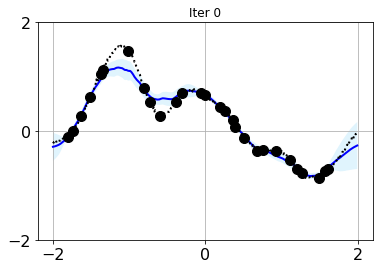

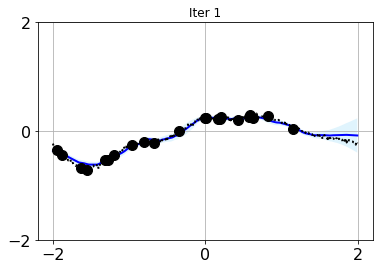

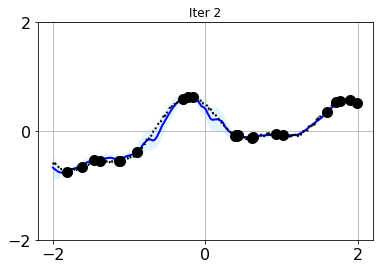

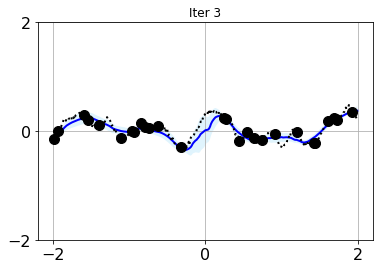

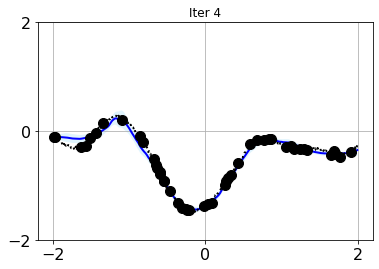

In [41]:
for i in range(3):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=i, seed=i)

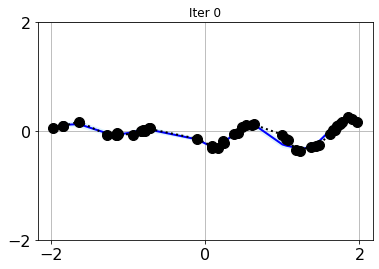

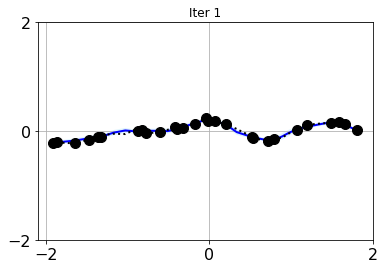

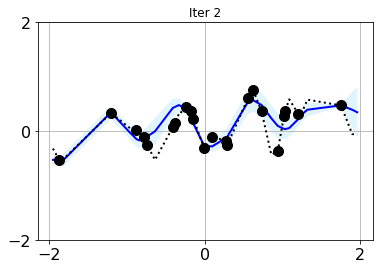

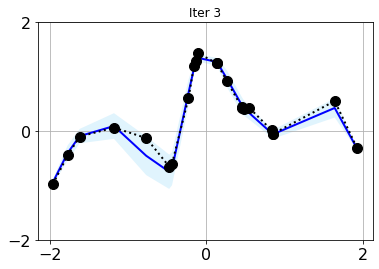

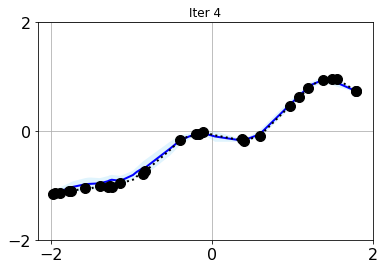

In [42]:
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=i, seed=i)

In [43]:
# Final validation
loss = torch.stack([test(model, dataset_test)[2] for _ in tqdm(range(100))]).mean().cpu()
print('val loss (n=100)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))


val loss (n=100) tensor(-0.9326)


## Improved

These have no been extensively tested:

- use torches ~50% faster multiheaded attention
- calc loss in log domain for stability (and untested changes to clipping)
- dropout

runs/Feb01_18-44-15_mjcdesktop-anp_1d_impr


train: 0 loss= 2.082 val_loss= 1.465


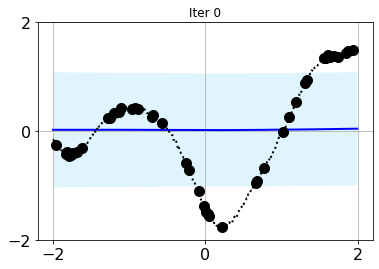

train: 1000 loss= 0.0669 val_loss= 0.2721
train: 2000 loss= 0.03866 val_loss= 1.889
train: 3000 loss=-0.1742 val_loss= 0.1717
train: 4000 loss=-0.4161 val_loss= 0.5655
train: 5000 loss= 0.2036 val_loss=-1.208
train: 6000 loss=-0.2205 val_loss=-0.1958
train: 7000 loss=-0.4805 val_loss=-1.411
train: 8000 loss=-0.265 val_loss=-0.5896
train: 9000 loss=-0.3367 val_loss= 0.5671
train: 10000 loss= 0.1358 val_loss=-1.043


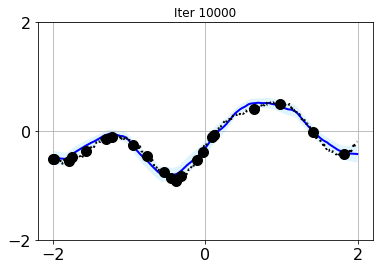

train: 11000 loss=-0.4013 val_loss=-0.3997
train: 12000 loss=-0.6028 val_loss= 0.1656
train: 13000 loss=-0.8203 val_loss=-0.6262
train: 14000 loss=-0.964 val_loss= 0.03497
train: 15000 loss=-0.134 val_loss=-1.76
train: 16000 loss=-0.6873 val_loss=-0.2673
train: 17000 loss=-0.9001 val_loss=-1.782
train: 18000 loss=-0.5137 val_loss=-0.9692
train: 19000 loss=-0.6706 val_loss= 0.4089
train: 20000 loss= 0.02585 val_loss=-0.9062


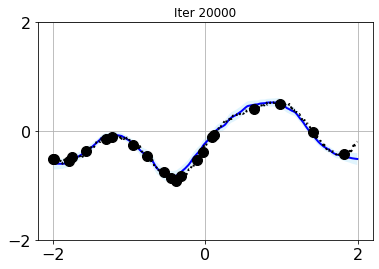

train: 21000 loss=-0.4756 val_loss=-0.7886
train: 22000 loss=-0.804 val_loss= 0.01887
train: 23000 loss=-1.075 val_loss=-0.601
train: 24000 loss=-1.189 val_loss=-0.1606
train: 25000 loss=-0.4006 val_loss=-1.998
train: 26000 loss=-0.8637 val_loss=-0.4377
train: 27000 loss=-1.054 val_loss=-1.729
train: 28000 loss=-0.7242 val_loss=-0.946
train: 29000 loss=-0.7902 val_loss= 0.3754
train: 30000 loss=-0.09739 val_loss=-0.9359


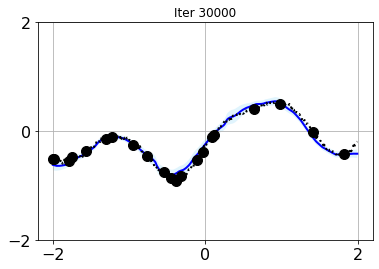

train: 31000 loss=-0.5755 val_loss=-0.9449
train: 32000 loss=-0.841 val_loss=-0.3225
train: 33000 loss=-1.172 val_loss=-0.6508
train: 34000 loss=-1.359 val_loss=-0.2052
train: 35000 loss=-0.5233 val_loss=-2.012
train: 36000 loss=-0.861 val_loss=-0.4675
train: 37000 loss=-1.173 val_loss=-1.794
train: 38000 loss=-0.828 val_loss=-0.9717
train: 39000 loss=-0.8202 val_loss= 0.2912
train: 40000 loss=-0.192 val_loss=-1.109


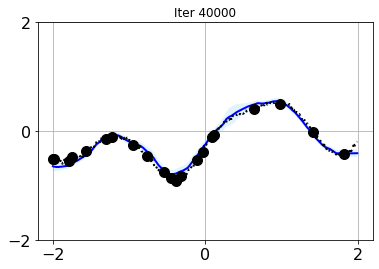

train: 41000 loss=-0.8205 val_loss=-1.016
train: 42000 loss=-0.952 val_loss=-0.6836
train: 43000 loss=-1.283 val_loss=-0.6939
train: 44000 loss=-1.436 val_loss=-0.298
train: 45000 loss=-0.6037 val_loss=-2.021
train: 46000 loss=-0.9512 val_loss=-0.5059
train: 47000 loss=-1.29 val_loss=-1.786
train: 48000 loss=-0.857 val_loss=-1.17
train: 49000 loss=-0.8692 val_loss= 0.3089
train: 50000 loss=-0.2524 val_loss=-1.184


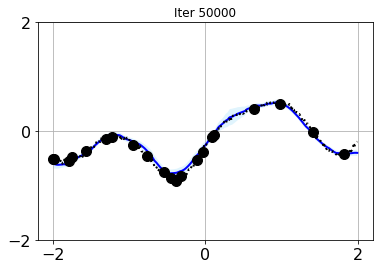

train: 51000 loss=-0.9286 val_loss=-1.034
train: 52000 loss=-0.9744 val_loss=-0.8707
train: 53000 loss=-1.309 val_loss=-0.7361
train: 54000 loss=-1.478 val_loss=-0.3777
train: 55000 loss=-0.659 val_loss=-1.942
train: 56000 loss=-0.9757 val_loss=-0.6741
train: 57000 loss=-1.356 val_loss=-1.75
train: 58000 loss=-0.9549 val_loss=-1.217
train: 59000 loss=-0.9542 val_loss= 0.2796
train: 60000 loss=-0.3208 val_loss=-1.304


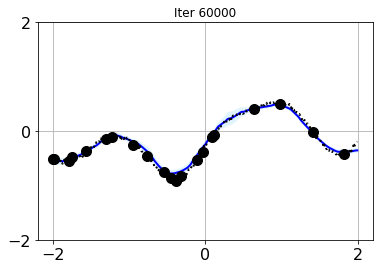

train: 61000 loss=-1.005 val_loss=-1.002
train: 62000 loss=-1.013 val_loss=-0.8435


KeyboardInterrupt: 

In [44]:
writer = SummaryWriter(comment='-anp_1d_impr')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="ptmultihead",
    det_enc_self_attn_type="ptmultihead",
    det_enc_cross_attn_type="ptmultihead",
    min_std=1e-3,
    use_lvar=True,
    use_self_attn=True,
#     attention_dropout=0.3,
#     dropout=0.3,
    batchnorm=True,
)
model = LatentModel(**hparams).cuda()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter % PLOT_AFTER == 0:
        test(model, dataset_test, writer, plot=True, global_step=n_iter)
        test(model, dataset_train, writer, plot=True, global_step=i, seed=n_iter)

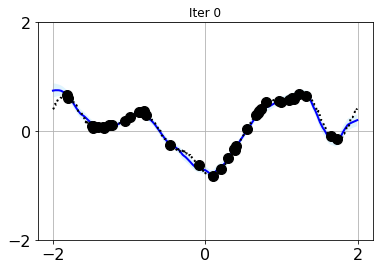

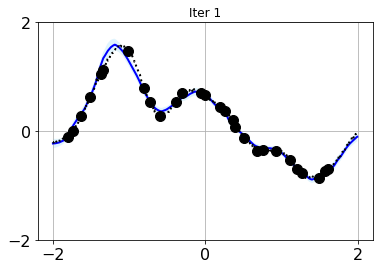

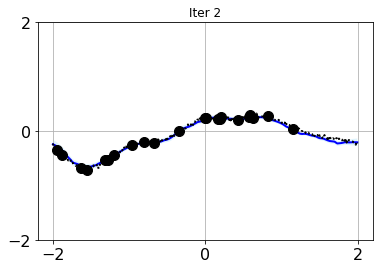

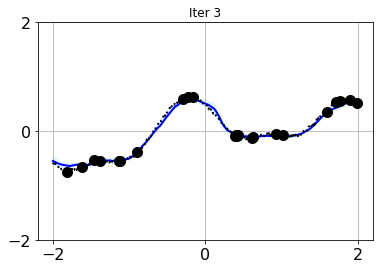

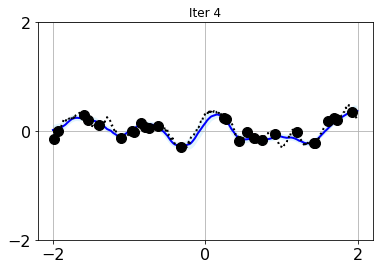

In [45]:
for i in range(3):
    test(model, dataset_test, writer, plot=True, global_step=i, seed=i)

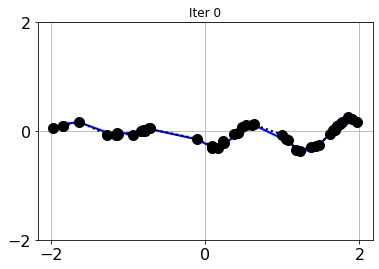

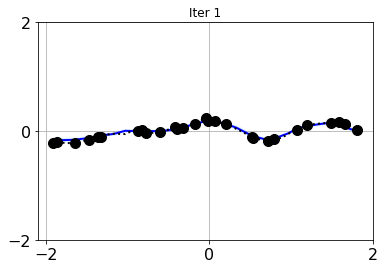

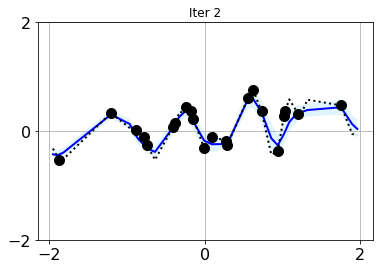

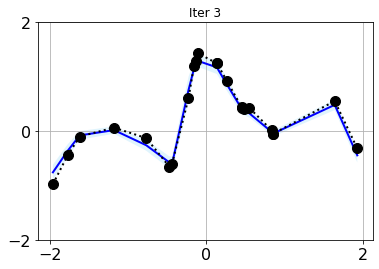

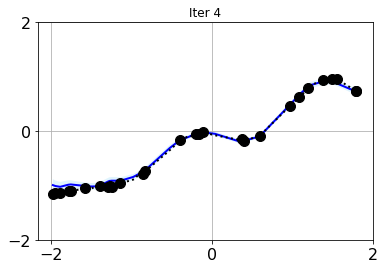

In [46]:
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=i, seed=i)

In [47]:
# Final validation
loss = torch.stack([test(model, dataset_test)[2] for _ in tqdm(range(100))]).mean().cpu()
print('val loss (n=100)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))


val loss (n=100) tensor(-1.2767)


In [48]:
(hparams, dict(val_loss=loss))

({'x_dim': 1,
  'y_dim': 1,
  'hidden_dim': 128,
  'latent_dim': 128,
  'latent_enc_self_attn_type': 'ptmultihead',
  'det_enc_self_attn_type': 'ptmultihead',
  'det_enc_cross_attn_type': 'ptmultihead',
  'min_std': 0.0001,
  'use_lvar': True,
  'use_self_attn': True,
  'batchnorm': True},
 {'val_loss': tensor(-1.2767)})